In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time

from threading import Thread
from threading import Lock

import multiprocessing

from sklearn.model_selection import train_test_split 

from src.Images import preprocess_images_from_dir
from src.Images import get_all_images_path
from src.Images import read_processed_image
from src.Images import plot_image
from src.Images import flatten_to_image

from src.Distances import euclidean_distance
from src.Distances import cosine_distance

from src.Knn import Knn

from src.Settings import *

from src.Parallel import thread_classify_function
from src.Parallel import split_data_into_chunks
from src.Parallel import presentation_thread_classify_function

print_all_settings()

USE_NUMPY_ARRAY: True
N_ROWS: 48
N_COLUMNS: 48
PREPROCESS_IMAGES: True
N_THREADS: 4
N_TESTS_USED: 200
WORKSPACE: .
DATASET_DIR: ./dataset
IMAGES_DIR: ./dataset/dataset
PROCESSED_IMAGES_PATH: ./dataset/dataset/_processed


In [2]:
def extract_class_from_path(path):
    return int(path.split(" ")[0].split("/")[-1])

def read_processed_image_to_numpy_array(path):
    return read_processed_image(path, GlobalSettings.N_ROWS, GlobalSettings.N_COLUMNS).flatten().reshape(-1,1)

def calculate_accumulated_variability(s, i):
    return 100*(np.sum(s[0:i])/np.sum(s))

def make_matrix_with_images_in_path(list_of_paths):
    return np.hstack([read_processed_image_to_numpy_array(path) for path in list_of_paths])

def centralize_matrix(matrix, mean_vector=None):
    if mean_vector is None:
        mean_vector = np.mean(matrix, axis=1, keepdims=True)
        
    centralized_data_matrix = matrix - mean_vector
    return centralized_data_matrix, mean_vector

def get_first_n_components(u, n):
    return u[:, :n]

def get_r_number_from_accumulated_variability(variability, s):
    r = 1
    
    while True:
        acc = calculate_accumulated_variability(s,r)
        if acc >= variability:
            return r
        else:
            r += 1
    

## Preprocessamento das imagens

In [3]:
if GlobalSettings.PREPROCESS_IMAGES:
    ans = input("Are you sure you want to preprocess all images? [type 'yes']")
    if ans == "yes":
        preprocess_images_from_dir(
            dir_path=GlobalSettings.IMAGES_DIR, n_rows=GlobalSettings.N_ROWS,
            n_columns=GlobalSettings.N_COLUMNS, extension="png"
        )

Are you sure you want to preprocess all images? [type 'yes'] no


## Paths para as imagens preprocessadas

In [4]:
images_path = get_all_images_path(GlobalSettings.PROCESSED_IMAGES_PATH)
images_path[:3]

['./dataset/dataset/_processed/14719 flat tile corner 2x2 000L.png',
 './dataset/dataset/_processed/14719 flat tile corner 2x2 000R.png',
 './dataset/dataset/_processed/14719 flat tile corner 2x2 001L.png']

In [5]:
data = [
    (
        extract_class_from_path(path),
        path,
    ) for path in images_path
]

In [6]:
y, x = zip(*data)
x = list(x)
y = list(y)

In [7]:
x_train_paths, x_test_paths, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

In [8]:
x_train = make_matrix_with_images_in_path(x_train_paths)
print("x_train.shape:", x_train.shape)

x_test = make_matrix_with_images_in_path(x_test_paths)
print("x_test.shape:", x_test.shape)

x_train.shape: (2304, 28000)
x_test.shape: (2304, 12000)


In [9]:
x_train_centralized, features_mean = centralize_matrix(x_train)
print("x_train_centralized.shape:", x_train_centralized.shape)

x_test_centralized, _ = centralize_matrix(x_test, features_mean)
print("x_test_centralized.shape:" ,x_test_centralized.shape)

x_train_centralized.shape: (2304, 28000)
x_test_centralized.shape: (2304, 12000)


In [10]:
u, s, vt = np.linalg.svd(x_train_centralized,full_matrices=False)

print("Dimensões de u:", u.shape)
print("Dimensões de s:", s.shape)
print("Dimensões de vt:", vt.shape)

Dimensões de u: (2304, 2304)
Dimensões de s: (2304,)
Dimensões de vt: (2304, 28000)


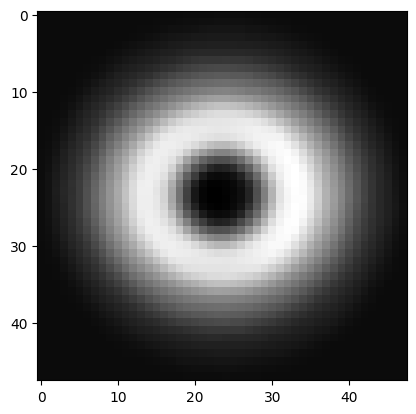

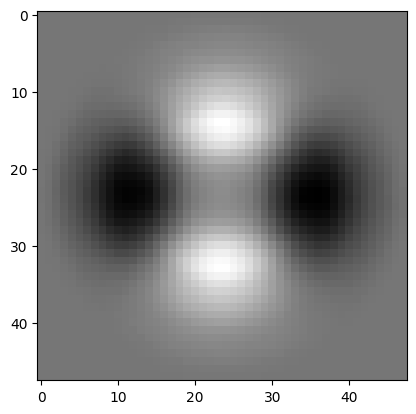

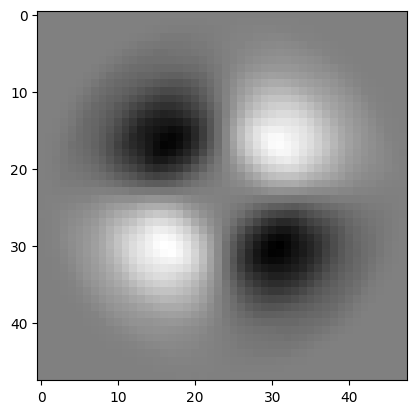

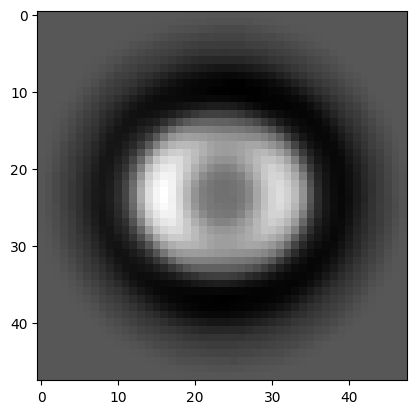

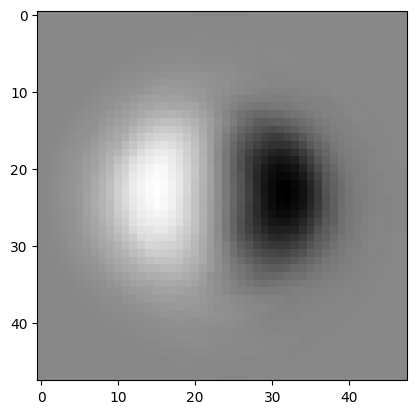

In [11]:
for i in range(5):
    img = u[:, i].reshape(GlobalSettings.N_ROWS, GlobalSettings.N_COLUMNS)
    plot_image(img)

In [12]:
eigen = np.array([0])
acc = np.array([0])
for i in range(0,len(s),10):
    acc = np.hstack((acc,100*(np.sum(s[0:i])/np.sum(s))))
    eigen = np.hstack((eigen,i))
    print("Vetores singulares (eigenfaces):", i, "- Variabilidade acumulada: {:.2f}%".format(calculate_accumulated_variability(s,i)))

Vetores singulares (eigenfaces): 0 - Variabilidade acumulada: 0.00%
Vetores singulares (eigenfaces): 10 - Variabilidade acumulada: 11.98%
Vetores singulares (eigenfaces): 20 - Variabilidade acumulada: 17.13%
Vetores singulares (eigenfaces): 30 - Variabilidade acumulada: 20.86%
Vetores singulares (eigenfaces): 40 - Variabilidade acumulada: 23.85%
Vetores singulares (eigenfaces): 50 - Variabilidade acumulada: 26.36%
Vetores singulares (eigenfaces): 60 - Variabilidade acumulada: 28.64%
Vetores singulares (eigenfaces): 70 - Variabilidade acumulada: 30.63%
Vetores singulares (eigenfaces): 80 - Variabilidade acumulada: 32.42%
Vetores singulares (eigenfaces): 90 - Variabilidade acumulada: 34.04%
Vetores singulares (eigenfaces): 100 - Variabilidade acumulada: 35.54%
Vetores singulares (eigenfaces): 110 - Variabilidade acumulada: 36.94%
Vetores singulares (eigenfaces): 120 - Variabilidade acumulada: 38.25%
Vetores singulares (eigenfaces): 130 - Variabilidade acumulada: 39.51%
Vetores singulares

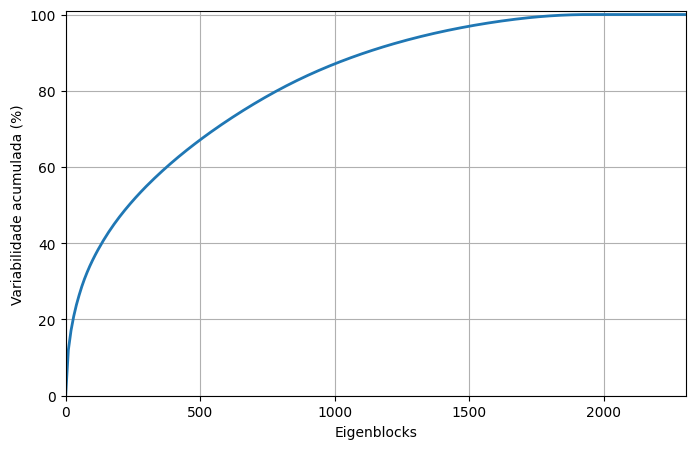

In [13]:
plt.figure(figsize=(8,5))
plt.plot(eigen,acc,linewidth=2.0)
plt.grid()
plt.ylabel("Variabilidade acumulada (%)")
plt.xlabel("Eigenblocks")
plt.axis([0,len(s),0,101])
plt.show()

In [14]:
r = 92
# r = get_r_number_from_accumulated_variability(22.2, s)

U_r = get_first_n_components(u, r)

x_train_projected = U_r.T @ x_train_centralized
print("x_train_projected.shape:", x_train_projected.shape)

x_test_projected = U_r.T @ x_test_centralized
print("x_test_projected.shape:", x_test_projected.shape)

x_train_projected.shape: (92, 28000)
x_test_projected.shape: (92, 12000)


In [15]:
acertos = 0
erros = 0

# for i in range(GlobalSettings.N_TESTS_USED):
for i in range(len(x_test_paths)):
    test_img_proj = x_test_projected[:, i]
    
    distances = np.linalg.norm(x_train_projected.T - test_img_proj, axis=1)
    
    # Find the nearest training sample
    nearest_index = np.argmin(distances)
    
    # Compare the class label of the nearest training sample to the test sample's label
    if y_test[i] == y_train[nearest_index]:
        acertos += 1
    else:
        erros += 1
       
total = acertos+erros

print("Quantidade de acertos:", acertos)
print("Quantidade de erros:", erros)
print("Total:", total)
print("Acurácia: {:.2f}%".format(100*(acertos/total)))

Quantidade de acertos: 7431
Quantidade de erros: 4569
Total: 12000
Acurácia: 61.92%


In [16]:
ACERTOS = []
ERROS = []
TAXA_ACERTOS = []
VARIABILIDADE_ACUMULADA = []
EIGENBLOCKS = []

for r in range(get_r_number_from_accumulated_variability(18, s), get_r_number_from_accumulated_variability(26, s), 1):
    U_r = get_first_n_components(u, r)

    x_train_projected = U_r.T @ x_train_centralized
    print("x_train_projected.shape:", x_train_projected.shape)
    
    x_test_projected = U_r.T @ x_test_centralized
    print("x_test_projected.shape:", x_test_projected.shape)
    
    acertos = 0
    erros = 0
    
    for i in range(GlobalSettings.N_TESTS_USED):
        test_img_proj = x_test_projected[:, i]
        
        distances = np.linalg.norm(x_train_projected.T - test_img_proj, axis=1)
        
        # Find the nearest training sample
        nearest_index = np.argmin(distances)
        
        # Compare the class label of the nearest training sample to the test sample's label
        if y_test[i] == y_train[nearest_index]:
            acertos += 1
        else:
            erros += 1
            
    total = acertos+erros

    ACERTOS.append(acertos)
    ERROS.append(erros)
    TAXA_ACERTOS.append(100*(acertos/total))
    VARIABILIDADE_ACUMULADA.append(calculate_accumulated_variability(s,r))
    EIGENBLOCKS.append(r)

    print("Quantidade de eigenblocks:", r)
    print("Quantidade de acertos:", acertos)
    print("Quantidade de erros:", erros)
    print("Total:", total)
    print("Acurácia: {:.2f}%".format(100*(acertos/total)))
    print("\n")

x_train_projected.shape: (23, 28000)
x_test_projected.shape: (23, 12000)
Quantidade de eigenblocks: 23
Quantidade de acertos: 119
Quantidade de erros: 81
Total: 200
Acurácia: 59.50%


x_train_projected.shape: (24, 28000)
x_test_projected.shape: (24, 12000)
Quantidade de eigenblocks: 24
Quantidade de acertos: 119
Quantidade de erros: 81
Total: 200
Acurácia: 59.50%


x_train_projected.shape: (25, 28000)
x_test_projected.shape: (25, 12000)
Quantidade de eigenblocks: 25
Quantidade de acertos: 118
Quantidade de erros: 82
Total: 200
Acurácia: 59.00%


x_train_projected.shape: (26, 28000)
x_test_projected.shape: (26, 12000)
Quantidade de eigenblocks: 26
Quantidade de acertos: 118
Quantidade de erros: 82
Total: 200
Acurácia: 59.00%


x_train_projected.shape: (27, 28000)
x_test_projected.shape: (27, 12000)
Quantidade de eigenblocks: 27
Quantidade de acertos: 121
Quantidade de erros: 79
Total: 200
Acurácia: 60.50%


x_train_projected.shape: (28, 28000)
x_test_projected.shape: (28, 12000)
Quantid

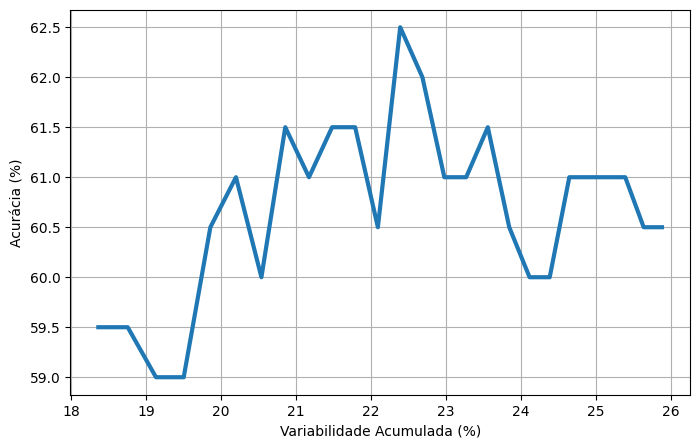

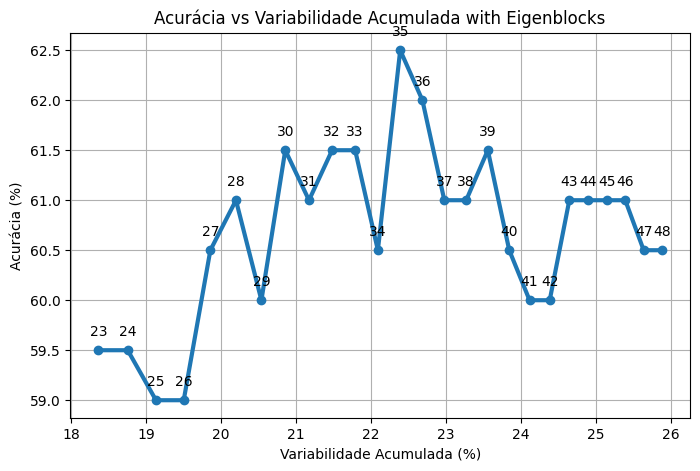

In [17]:
acertos = np.array(ACERTOS)
erros = np.array(ERROS)
taxaAcerto = np.array(TAXA_ACERTOS)
variabilidadeAcumulada = np.array(VARIABILIDADE_ACUMULADA)
num_eigenblocks = np.array(EIGENBLOCKS)

plt.figure(figsize=(8,5))
plt.plot(variabilidadeAcumulada,taxaAcerto,lw=3.0)
plt.grid()
plt.ylabel("Acurácia (%)")
plt.xlabel("Variabilidade Acumulada (%)")
plt.show()


plt.figure(figsize=(8,5))
plt.plot(variabilidadeAcumulada, taxaAcerto, lw=3.0, marker='o')

# Add annotations for each point
for x, y, n in zip(variabilidadeAcumulada, taxaAcerto, num_eigenblocks):
    plt.annotate(f'{n}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid()
plt.ylabel("Acurácia (%)")
plt.xlabel("Variabilidade Acumulada (%)")
plt.title("Acurácia vs Variabilidade Acumulada with Eigenblocks")
plt.show()

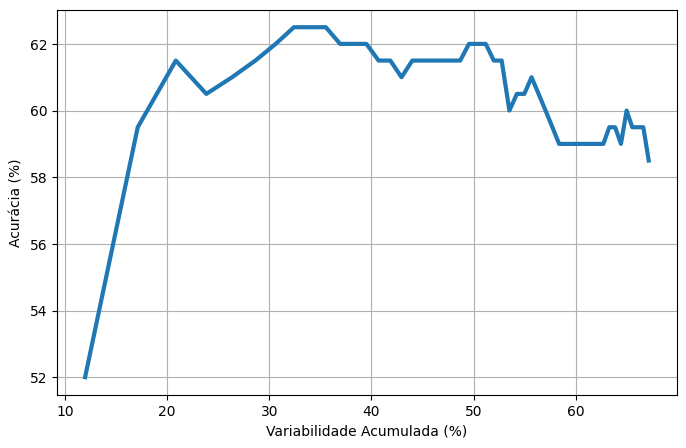

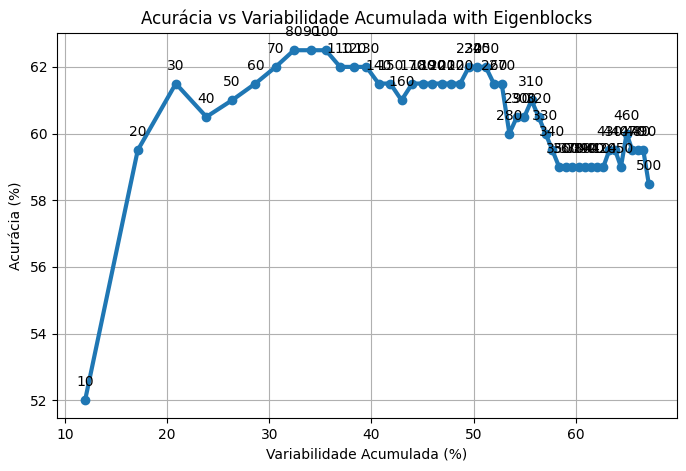

In [18]:
ACERTOS = []
ERROS = []
TAXA_ACERTOS = []
VARIABILIDADE_ACUMULADA = []
EIGENBLOCKS = []

for r in range(10, 501, 10):
    U_r = get_first_n_components(u, r)

    x_train_projected = U_r.T @ x_train_centralized
    
    x_test_projected = U_r.T @ x_test_centralized
    
    acertos = 0
    erros = 0
    
    for i in range(GlobalSettings.N_TESTS_USED):
        test_img_proj = x_test_projected[:, i]
        
        distances = np.linalg.norm(x_train_projected.T - test_img_proj, axis=1)
        
        # Find the nearest training sample
        nearest_index = np.argmin(distances)
        
        # Compare the class label of the nearest training sample to the test sample's label
        if y_test[i] == y_train[nearest_index]:
            acertos += 1
        else:
            erros += 1
            
    total = acertos+erros

    ACERTOS.append(acertos)
    ERROS.append(erros)
    TAXA_ACERTOS.append(100*(acertos/total))
    VARIABILIDADE_ACUMULADA.append(calculate_accumulated_variability(s,r))
    EIGENBLOCKS.append(r)

acertos = np.array(ACERTOS)
erros = np.array(ERROS)
taxaAcerto = np.array(TAXA_ACERTOS)
variabilidadeAcumulada = np.array(VARIABILIDADE_ACUMULADA)
num_eigenblocks = np.array(EIGENBLOCKS)

plt.figure(figsize=(8,5))
plt.plot(variabilidadeAcumulada,taxaAcerto,lw=3.0)
plt.grid()
plt.ylabel("Acurácia (%)")
plt.xlabel("Variabilidade Acumulada (%)")
plt.show()


plt.figure(figsize=(8,5))
plt.plot(variabilidadeAcumulada, taxaAcerto, lw=3.0, marker='o')

# Add annotations for each point
for x, y, n in zip(variabilidadeAcumulada, taxaAcerto, num_eigenblocks):
    plt.annotate(f'{n}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid()
plt.ylabel("Acurácia (%)")
plt.xlabel("Variabilidade Acumulada (%)")
plt.title("Acurácia vs Variabilidade Acumulada with Eigenblocks")
plt.show()

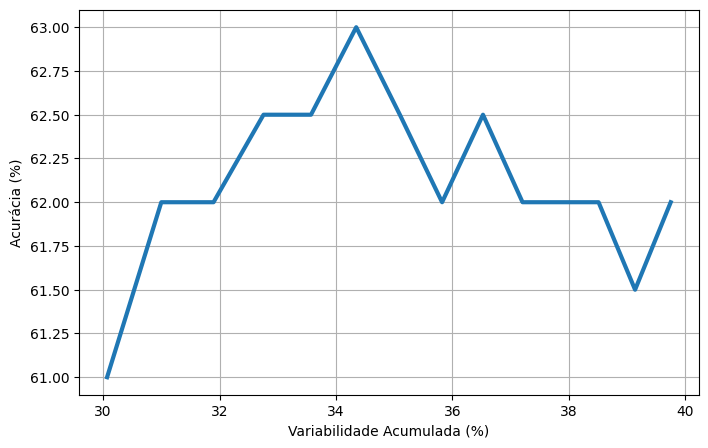

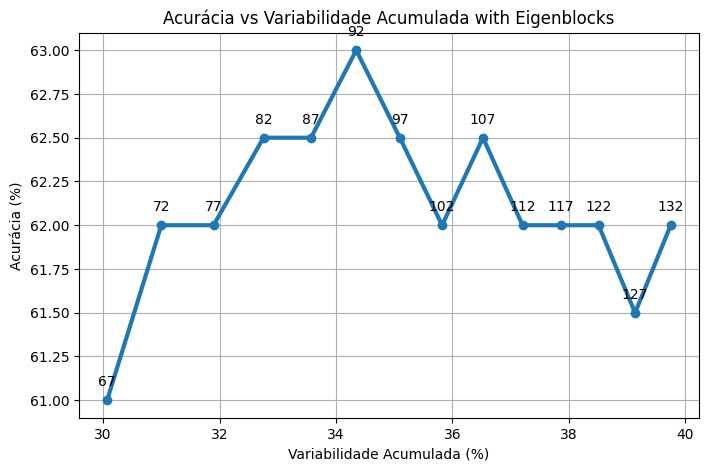

In [19]:
ACERTOS = []
ERROS = []
TAXA_ACERTOS = []
VARIABILIDADE_ACUMULADA = []
EIGENBLOCKS = []

for r in range(get_r_number_from_accumulated_variability(30, s), get_r_number_from_accumulated_variability(40, s), 5):
    U_r = get_first_n_components(u, r)

    x_train_projected = U_r.T @ x_train_centralized
    
    x_test_projected = U_r.T @ x_test_centralized
    
    acertos = 0
    erros = 0
    
    for i in range(GlobalSettings.N_TESTS_USED):
        test_img_proj = x_test_projected[:, i]
        
        distances = np.linalg.norm(x_train_projected.T - test_img_proj, axis=1)
        
        # Find the nearest training sample
        nearest_index = np.argmin(distances)
        
        # Compare the class label of the nearest training sample to the test sample's label
        if y_test[i] == y_train[nearest_index]:
            acertos += 1
        else:
            erros += 1
            
    total = acertos+erros

    ACERTOS.append(acertos)
    ERROS.append(erros)
    TAXA_ACERTOS.append(100*(acertos/total))
    VARIABILIDADE_ACUMULADA.append(calculate_accumulated_variability(s,r))
    EIGENBLOCKS.append(r)

acertos = np.array(ACERTOS)
erros = np.array(ERROS)
taxaAcerto = np.array(TAXA_ACERTOS)
variabilidadeAcumulada = np.array(VARIABILIDADE_ACUMULADA)
num_eigenblocks = np.array(EIGENBLOCKS)

plt.figure(figsize=(8,5))
plt.plot(variabilidadeAcumulada,taxaAcerto,lw=3.0)
plt.grid()
plt.ylabel("Acurácia (%)")
plt.xlabel("Variabilidade Acumulada (%)")
plt.show()


plt.figure(figsize=(8,5))
plt.plot(variabilidadeAcumulada, taxaAcerto, lw=3.0, marker='o')

# Add annotations for each point
for x, y, n in zip(variabilidadeAcumulada, taxaAcerto, num_eigenblocks):
    plt.annotate(f'{n}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid()
plt.ylabel("Acurácia (%)")
plt.xlabel("Variabilidade Acumulada (%)")
plt.title("Acurácia vs Variabilidade Acumulada with Eigenblocks")
plt.show()

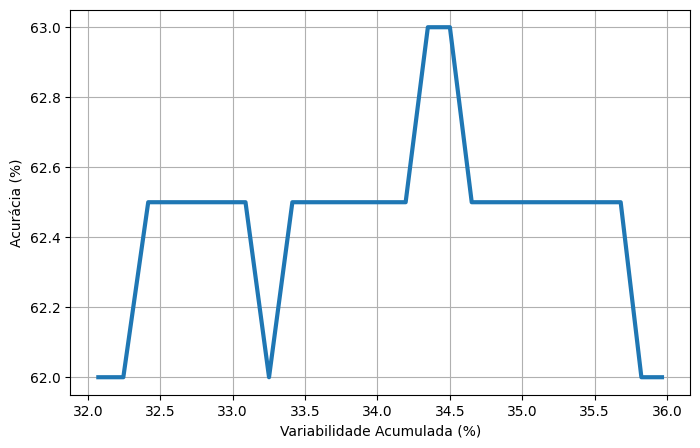

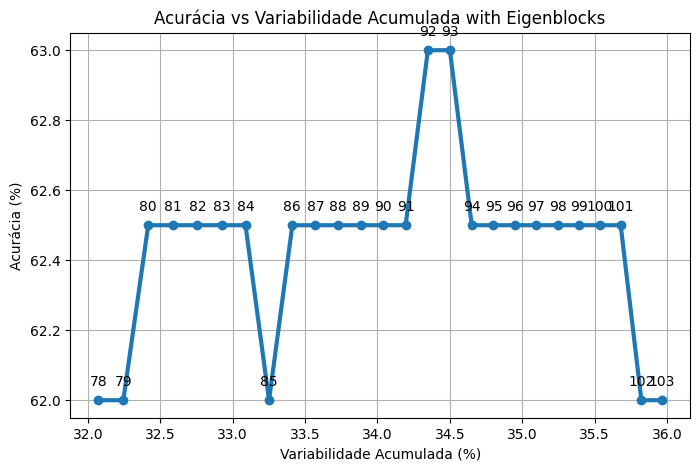

In [20]:
ACERTOS = []
ERROS = []
TAXA_ACERTOS = []
VARIABILIDADE_ACUMULADA = []
EIGENBLOCKS = []

for r in range(get_r_number_from_accumulated_variability(32, s), get_r_number_from_accumulated_variability(36, s), 1):
    U_r = get_first_n_components(u, r)

    x_train_projected = U_r.T @ x_train_centralized
    
    x_test_projected = U_r.T @ x_test_centralized
    
    acertos = 0
    erros = 0
    
    for i in range(GlobalSettings.N_TESTS_USED):
        test_img_proj = x_test_projected[:, i]
        
        distances = np.linalg.norm(x_train_projected.T - test_img_proj, axis=1)
        
        # Find the nearest training sample
        nearest_index = np.argmin(distances)
        
        # Compare the class label of the nearest training sample to the test sample's label
        if y_test[i] == y_train[nearest_index]:
            acertos += 1
        else:
            erros += 1
            
    total = acertos+erros

    ACERTOS.append(acertos)
    ERROS.append(erros)
    TAXA_ACERTOS.append(100*(acertos/total))
    VARIABILIDADE_ACUMULADA.append(calculate_accumulated_variability(s,r))
    EIGENBLOCKS.append(r)

acertos = np.array(ACERTOS)
erros = np.array(ERROS)
taxaAcerto = np.array(TAXA_ACERTOS)
variabilidadeAcumulada = np.array(VARIABILIDADE_ACUMULADA)
num_eigenblocks = np.array(EIGENBLOCKS)

plt.figure(figsize=(8,5))
plt.plot(variabilidadeAcumulada,taxaAcerto,lw=3.0)
plt.grid()
plt.ylabel("Acurácia (%)")
plt.xlabel("Variabilidade Acumulada (%)")
plt.show()


plt.figure(figsize=(8,5))
plt.plot(variabilidadeAcumulada, taxaAcerto, lw=3.0, marker='o')

# Add annotations for each point
for x, y, n in zip(variabilidadeAcumulada, taxaAcerto, num_eigenblocks):
    plt.annotate(f'{n}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid()
plt.ylabel("Acurácia (%)")
plt.xlabel("Variabilidade Acumulada (%)")
plt.title("Acurácia vs Variabilidade Acumulada with Eigenblocks")
plt.show()